Датасет: [MotionSense Dataset](https://github.com/mmalekzadeh/motion-sense)

Содержит показания с частотой 50Гц

Активности: downstairs, upstairs, walking, jogging, sitting, and standing
Данные: "attitude", "gravity", "rotationRate", "userAcceleration":

Поле **id** отвечает за номер человека, который производил активность.


Скачаем этот датасет:

In [ ]:
from google.colab import drive
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm_notebook
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt


drive.mount("/content/drive")

#warnings.simplefilter('ignore')

plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 8

Mounted at /content/drive


#### 1. Скачивание и распаковка датасета.

In [ ]:
!git clone https://github.com/mmalekzadeh/motion-sense.git

Cloning into 'motion-sense'...
remote: Enumerating objects: 612, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 612 (delta 4), reused 4 (delta 4), pack-reused 605
Receiving objects: 100% (612/612), 201.77 MiB | 43.08 MiB/s, done.
Resolving deltas: 100% (296/296), done.
Updating files: 100% (74/74), done.


разархивируем в content все его части (также есть на моем гугл-диске по адресу /content/drive/MyDrive/metric_analysis/datasets/motion-sense) (/content/)

In [ ]:
!cp /content/motion-sense/data/data_subjects_info.csv -d .
!unzip -q /content/motion-sense/data/A_DeviceMotion_data.zip -d .
!unzip -q /content/motion-sense/data/B_Accelerometer_data.zip -d .
!unzip -q /content/motion-sense/data/C_Gyroscope_data.zip -d .

In [ ]:
# !cp /content/motion-sense/data/* /content/drive/MyDrive/metric_analysis/datasets/motion-sense
# !unzip -q /content/drive/MyDrive/metric_analysis/datasets/motion-sense/A_DeviceMotion_data.zip -d /content/drive/MyDrive/metric_analysis/datasets/motion-sense/
# !unzip -q /content/drive/MyDrive/metric_analysis/datasets/motion-sense/B_Accelerometer_data.zip -d /content/drive/MyDrive/metric_analysis/datasets/motion-sense/
# !unzip -q /content/drive/MyDrive/metric_analysis/datasets/motion-sense/C_Gyroscope_data.zip -d /content/drive/MyDrive/metric_analysis/datasets/motion-sense/

Из датасета с большим количеством измерений берем только "userAcceleration" во время ходьбы "wlk"

In [ ]:
freq = 50 # частота замера = 50ГЦ

def get_ds_infos():
    """
    Read the file includes data subject information.
    
    Data Columns:
    0: code [1-24]
    1: weight [kg]
    2: height [cm]
    3: age [years]
    4: gender [0:Female, 1:Male]
    
    Returns:
        A pandas DataFrame that contains inforamtion about data subjects' attributes 
    """ 

    dss = pd.read_csv("data_subjects_info.csv")
    print("[INFO] -- Data subjects' information is imported.")
    
    return dss

def set_data_types(data_types=["userAcceleration"]):
    """
    Select the sensors and the mode to shape the final dataset.
    
    Args:
        data_types: A list of sensor data type from this list: [attitude, gravity, rotationRate, userAcceleration] 

    Returns:
        It returns a list of columns to use for creating time-series from files.
    """
    dt_list = []
    for t in data_types:
        if t != "attitude":
            dt_list.append([t+".x",t+".y",t+".z"])
        else:
            dt_list.append([t+".roll", t+".pitch", t+".yaw"])

    return dt_list


def creat_time_series(dt_list, act_labels, trial_codes, mode="mag", labeled=True):
    """
    Args:
        dt_list: A list of columns that shows the type of data we want.
        act_labels: list of activites
        trial_codes: list of trials
        mode: It can be "raw" which means you want raw data
        for every dimention of each data type,
        [attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z)].
        or it can be "mag" which means you only want the magnitude for each data type: (x^2+y^2+z^2)^(1/2)
        labeled: True, if we want a labeld dataset. False, if we only want sensor values.

    Returns:
        It returns a time-series of sensor data.
    
    """
    num_data_cols = len(dt_list) if mode == "mag" else len(dt_list*3)

    if labeled:
        dataset = np.zeros((0,num_data_cols+7)) # "7" --> [act, code, weight, height, age, gender, trial] 
    else:
        dataset = np.zeros((0,num_data_cols))
        
    ds_list = get_ds_infos()
    
    print("[INFO] -- Creating Time-Series")
    for sub_id in ds_list["code"]:
        for act_id, act in enumerate(act_labels):
            for trial in trial_codes[act_id]:
                fname = 'A_DeviceMotion_data/'+act+'_'+str(trial)+'/sub_'+str(int(sub_id))+'.csv'
                raw_data = pd.read_csv(fname)
                raw_data = raw_data.drop(['Unnamed: 0'], axis=1)
                vals = np.zeros((len(raw_data), num_data_cols))
                for x_id, axes in enumerate(dt_list):
                    if mode == "mag":
                        vals[:,x_id] = (raw_data[axes]**2).sum(axis=1)**0.5        
                    else:
                        vals[:,x_id*3:(x_id+1)*3] = raw_data[axes].values
                    vals = vals[:,:num_data_cols]
                if labeled:
                    lbls = np.array([[act_id,
                            sub_id-1,
                            ds_list["weight"][sub_id-1],
                            ds_list["height"][sub_id-1],
                            ds_list["age"][sub_id-1],
                            ds_list["gender"][sub_id-1],
                            trial          
                           ]]*len(raw_data))
                    vals = np.concatenate((vals, lbls), axis=1)
                dataset = np.append(dataset,vals, axis=0)
    cols = []
    for axes in dt_list:
        if mode == "raw":
            cols += axes
        else:
            cols += [str(axes[0][:-2])]
            
    if labeled:
        cols += ["act", "id", "weight", "height", "age", "gender", "trial"]
    
    dataset = pd.DataFrame(data=dataset, columns=cols)
    return dataset
#________________________________


ACT_LABELS = ["dws","ups", "wlk", "jog", "std", "sit"]
TRIAL_CODES = {
    ACT_LABELS[0]:[1,2,11],
    ACT_LABELS[1]:[3,4,12],
    ACT_LABELS[2]:[7,8,15],
    ACT_LABELS[3]:[9,16],
    ACT_LABELS[4]:[6,14],
    ACT_LABELS[5]:[5,13]
}

## Here we set parameter to build labeld time-series from dataset of "(A)DeviceMotion_data"
## attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z)
sdt = ["userAcceleration"] # attitude, gravity, rotationRate, userAcceleration
print("[INFO] -- Selected sensor data types: "+str(sdt))    
act_labels = ["wlk"] # ACT_LABELS [2:3]
print("[INFO] -- Selected activites: "+str(act_labels))    
trial_codes = [TRIAL_CODES[act] for act in act_labels]
dt_list = set_data_types(sdt)
print(dt_list)
dataset = creat_time_series(dt_list, act_labels, trial_codes, mode="raw", labeled=True)
print("[INFO] -- Shape of time-Series dataset:"+str(dataset.shape))    
dataset.head()

[INFO] -- Selected sensor data types: ['userAcceleration']
[INFO] -- Selected activites: ['wlk']
[['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']]
[INFO] -- Data subjects' information is imported.
[INFO] -- Creating Time-Series
[INFO] -- Shape of time-Series dataset:(344288, 10)


,userAcceleration.x,userAcceleration.y,userAcceleration.z,act,id,weight,height,age,gender,trial
0,0.091702,0.415881,0.093689,0.0,0.0,102.0,188.0,46.0,1.0,7.0
1,0.367412,0.004566,-0.106082,0.0,0.0,102.0,188.0,46.0,1.0,7.0
2,0.172093,-0.217483,-0.163387,0.0,0.0,102.0,188.0,46.0,1.0,7.0
3,0.004957,-0.237566,-0.019080,0.0,0.0,102.0,188.0,46.0,1.0,7.0
4,-0.040292,-0.241461,0.015201,0.0,0.0,102.0,188.0,46.0,1.0,7.0


Возьмем userAcceleration по x-y для id=0.0 (первый участник) и далее будем использовать его


In [ ]:
first_user_data = dataset[dataset['id'] == 0.0]
first_user_data

,userAcceleration.x,userAcceleration.y,userAcceleration.z,act,id,weight,height,age,gender,trial
0,0.091702,0.415881,0.093689,0.0,0.0,102.0,188.0,46.0,1.0,7.0
1,0.367412,0.004566,-0.106082,0.0,0.0,102.0,188.0,46.0,1.0,7.0
2,0.172093,-0.217483,-0.163387,0.0,0.0,102.0,188.0,46.0,1.0,7.0
3,0.004957,-0.237566,-0.019080,0.0,0.0,102.0,188.0,46.0,1.0,7.0
4,-0.040292,-0.241461,0.015201,0.0,0.0,102.0,188.0,46.0,1.0,7.0
...,...,...,...,...,...,...,...,...,...,...
11107,0.045689,0.611858,-0.873182,0.0,0.0,102.0,188.0,46.0,1.0,15.0
11108,0.404748,1.027273,-0.621450,0.0,0.0,102.0,188.0,46.0,1.0,15.0
11109,0.407576,0.258908,-0.084899,0.0,0.0,102.0,188.0,46.0,1.0,15.0
11110,0.230798,-0.047420,0.175331,0.0,0.0,102.0,188.0,46.0,1.0,15.0


In [ ]:
first_user_data.describe()

,userAcceleration.x,userAcceleration.y,userAcceleration.z,act,id,weight,height,age,gender,trial
count,11112.000000,11112.000000,11112.000000,11112.0,11112.0,11112.0,11112.0,11112.0,11112.0,11112.000000
mean,0.059449,0.177968,-0.259180,0.0,0.0,102.0,188.0,46.0,1.0,8.350252
std,0.492574,0.639860,0.512329,0.0,0.0,0.0,0.0,0.0,0.0,2.499083
min,-3.330301,-1.645164,-2.616230,0.0,0.0,102.0,188.0,46.0,1.0,7.000000
25%,-0.226270,-0.314715,-0.573816,0.0,0.0,102.0,188.0,46.0,1.0,7.000000
50%,0.078264,0.139191,-0.226753,0.0,0.0,102.0,188.0,46.0,1.0,8.000000
75%,0.391761,0.601875,0.085896,0.0,0.0,102.0,188.0,46.0,1.0,8.000000
max,1.968308,2.708035,1.518116,0.0,0.0,102.0,188.0,46.0,1.0,15.000000


#### 2. Визуализация  данных

In [ ]:
x_acc = first_user_data['userAcceleration.x']
sec_times = np.arange(len(x_acc)) / freq

vis_mask = (sec_times < 13) # покажем только первые 10 сек

fig = go.Figure()
fig.add_trace(go.Scatter(x=sec_times[vis_mask],
                            y = x_acc[vis_mask],
                            mode='lines', 
                            name='x_acc'))

fig.update_layout(
    title="User#0 x-acceleration during walking",
    xaxis_title="time, sec",
    yaxis_title="Acceleration",
    legend_title="Legend Title",
    font=dict(
        family="DejaVu Serif",
        size=18,
        color="RebeccaPurple"
    )
)

fig.show()

#### 3. Изменение частоты и использование 2NN для восстановления

In [ ]:
!pip install geotorch -q

from drive.MyDrive.metric_analysis.modules.classes_and_functions import *
from drive.MyDrive.metric_analysis.modules.model_arch import *
from drive.MyDrive.metric_analysis.modules.visualization import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 kB 2.8 MB/s eta 0:00:00


Приближенно (да и из графика видно) считаем, что 1 шаг совершается за 1 секунду.

Тогда 2 шага занимают 2 секунды. Именно такое время мы и будем восстанавливать

In [ ]:
period = 2 # 2 секунды мы даем на вход модели

steps_in_time = period * freq # сколько моментов времени в периуде
print(steps_in_time)

100


#### 4. Снижение размерности для архитектуры 100-10-100 с помощью среднего!

In [ ]:
in_len = steps_in_time
hid_dim = 10
out_len = steps_in_time

batch_size = 16
lr = 1e-3

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)

dataset = TimeSerie_1d_Dataset(in_len=in_len, 
                               out_len=out_len, 
                               s_noice=first_user_data['userAcceleration.x'], 
                               s_true=None)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = NN_2(in_len=in_len, hid_dim=hid_dim, out_len=out_len).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4, threshold=0.001, verbose=True)

cuda:0


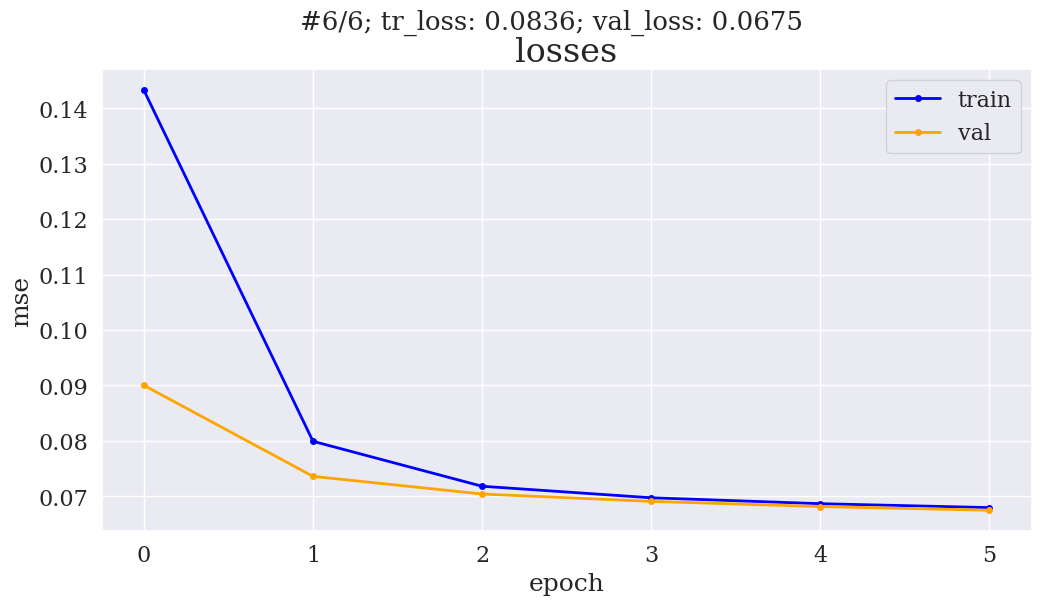

In [ ]:
model, optimizer, losses = learning_loop(
    model = model,
    optimizer = optimizer,
    loader = dataloader,
    criterion = criterion,
    epochs=6,
    draw_every=1,
    separate_show=False,
    device=device
)

Теперь запустим обучение 100 моделей для оценки дисперсий/ковариаций.

In [ ]:
path = '/content/drive/MyDrive/metric_analysis/2NN_experiment_accel_100_10_100'
!mkdir $path # создание папка
N = 100
max_epochs = 5

In [ ]:
# Обучение моделей

models = []
losses = []

for i in tqdm_notebook(range(N)):
    model = NN_2(in_len=in_len, hid_dim=hid_dim, out_len=out_len).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    model, optimizer, losses_tr = learning_loop(
        model = model,
        optimizer = optimizer,
        loader = dataloader,
        criterion = criterion,
        epochs = max_epochs,
        val_every=max_epochs+1, 
        draw_every=max_epochs+1,
        separate_show=False,
        device=device
    )

    models.append(model)
    losses.append(losses_tr['train'][-1])
    print(f'Loss #{i + 1}: {losses_tr["train"][-1]:.3f}')

    torch.save(model.state_dict(), path + f"/nn_{i + 1}.pth")

In [ ]:
# загрузка моделей

models = []

for i in range(1, N + 1):
    model = NN_2(in_len=in_len, hid_dim=hid_dim, out_len=out_len).to(device)
    model.load_state_dict(torch.load(path + f'/nn_{i}.pth'))
    models.append(model)

Теперь на скрытом слое имеем 100 нейронов размерности 10.

Будем объединять одинаковые по **среднему**.

используем $W_2$

In [ ]:
W2_matrices = np.array([models[i].W2.weight.detach().cpu().numpy() for i in range(len(models))])
print(W2_matrices.shape)

means = W2_matrices.mean(axis=0)
variances = np.array([np.cov(W2_matrices[:, i, :], rowvar=False) for i in range(out_len)])
correlations = np.array([np.corrcoef(W2_matrices[:, i, :], rowvar=False) for i in range(out_len)])
print(means.shape, variances.shape)

(100, 100, 10)
(100, 10) (100, 10, 10)


In [ ]:
import copy

def estimate_quality(W2_weight):
    model_1 = copy.deepcopy(models[0])
    with torch.no_grad():
        model_1.W2.weight = W2_weight
    
    return validate(model_1, loader = dataloader,
        criterion = criterion, device=device)

Оценка качества.

In [ ]:
from sklearn.cluster import KMeans

def change_weights(W2weight, labels):
    '''
        labels: list with ints; We change weight of cluster as mean weight!
    '''
    with torch.no_grad():
        new_weights = copy.deepcopy(W2weight)

        unique_labels = np.unique(labels)

        for lab in unique_labels:
            new_weights[labels == lab, :] = new_weights[labels == lab, :].mean(axis=0, keepdims=True)
        
    return new_weights

In [ ]:
# проверка корректности
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(means)
new_weights = change_weights(models[0].W2.weight, kmeans.labels_)
estimate_quality(new_weights)

0.2360541952019679

In [ ]:
models[0].W2.weight.shape

torch.Size([100, 10])

In [ ]:
means.shape

(100, 10)

In [ ]:
qualities = []

cluster_range = list(range(1, models[0].W2.weight.shape[0], 5))

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit(means)

    new_weights = change_weights(models[0].W2.weight, kmeans.labels_)
    quality = estimate_quality(new_weights)

    qualities.append(quality)
    print(f'clust: {n_clusters}, quality: {quality:.3f}')

clust: 1, quality: 0.255
clust: 6, quality: 0.186
clust: 11, quality: 0.159
clust: 16, quality: 0.125
clust: 21, quality: 0.105
clust: 26, quality: 0.099
clust: 31, quality: 0.092
clust: 36, quality: 0.089
clust: 41, quality: 0.088
clust: 46, quality: 0.086
clust: 51, quality: 0.085
clust: 56, quality: 0.080
clust: 61, quality: 0.078
clust: 66, quality: 0.076
clust: 71, quality: 0.076
clust: 76, quality: 0.074
clust: 81, quality: 0.073
clust: 86, quality: 0.073
clust: 91, quality: 0.071
clust: 96, quality: 0.070


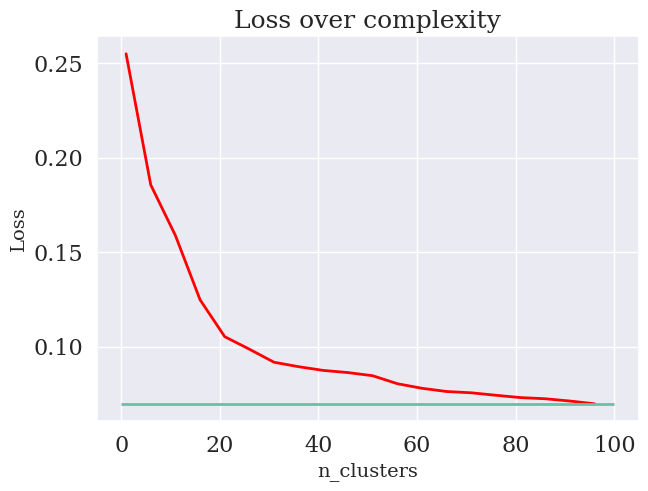

In [ ]:
plt.figure(figsize=(7, 5))
plt.plot(cluster_range, qualities, linewidth=2, c='r')
plt.title('Loss over complexity', fontsize=18)

plt.hlines(0.07, 0, 100)

plt.ylabel('Loss', fontsize=14)
plt.xlabel('n_clusters', fontsize=14);

Теперь используем ковариации и Wassershtine distance: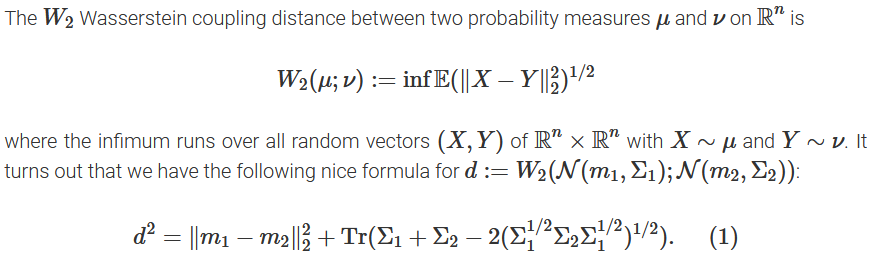

In [ ]:
class GaussianPoint:
    def __init__(self, mean, var):
        self.mean = mean
        self.var = var
        self.shape = mean.shape

    def __len__(self):
        return len(self.mean)

In [ ]:
np.concatenate([means[0], variances[0].reshape(-1)]).shape

(110,)

In [ ]:
neural_dim = 10

In [ ]:
gau_points = [np.concatenate([means[i], variances[i].reshape(-1)]) for i in range(len(means))]

In [ ]:
from scipy.linalg import sqrtm

def get_wassershtine_distance(mu_1, Sigma_1, mu_2, Sigma_2):

    sqrt_Sigma_1 = sqrtm(Sigma_1)
    d_sq = np.sum((mu_1 - mu_2)**2) + np.trace(Sigma_1 + Sigma_2 - 2 * sqrtm(sqrt_Sigma_1 @ Sigma_2 @ sqrt_Sigma_1))
    
    if np.abs(d_sq) < 1e-7:
        d_sq = 0
    
    #assert d_sq >= 0, d_sq
    return np.sqrt(d_sq)

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
!pip3 install pyclustering

In [ ]:
from pyclustering.cluster.kmeans import kmeans
from pyclustering.utils.metric import type_metric, distance_metric
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

In [ ]:
user_function = lambda point1, point2: get_wassershtine_distance(point1[:neural_dim], point1[neural_dim:].reshape(neural_dim, neural_dim), point2[:neural_dim], point2[neural_dim:].reshape(neural_dim, neural_dim))
metric = distance_metric(type_metric.USER_DEFINED, func=user_function)

In [ ]:
n_clusters = 2

initial_centers = gau_points[:n_clusters]

kmeans_instance = kmeans(gau_points, metric=metric, initial_centers=initial_centers)

In [ ]:
kmeans_instance.process()
clusters = kmeans_instance.get_clusters()

In [ ]:
labels = np.zeros(shape=models[0].W2.weight.shape[0])
for i, lst in enumerate(clusters):
    labels[lst] = i
print(labels)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0.]


In [ ]:
n_clusters = 8

initial_centers = gau_points[:n_clusters]
kmeans_instance = kmeans(gau_points, metric=metric, initial_centers=initial_centers)

In [ ]:
kmeans_plusplus_initializer(gau_points, amount_centers=2).initialize()

In [ ]:
from tqdm.auto import tqdm
qualities_wass = []

cluster_range = list(range(2, models[0].W2.weight.shape[0], 5))

for n_clusters in tqdm(cluster_range):
    initial_centers = kmeans_plusplus_initializer(gau_points, amount_centers=n_clusters).initialize()
    kmeans_instance = kmeans(gau_points, metric=metric, initial_centers=initial_centers)
    kmeans_instance.process()

    lab_list = kmeans_instance.get_clusters()
    # print(lab_list)
    labels = np.zeros(shape=models[0].W2.weight.shape[0])
    for i, lst in enumerate(lab_list):
        labels[lst] = i

    new_weights = change_weights(models[0].W2.weight, labels)
    quality = estimate_quality(new_weights)

    qualities_wass.append(quality)
    print(f'clust: {n_clusters}, quality: {quality:.3f}')

  0%|          | 0/20 [00:00<?, ?it/s]

clust: 2, quality: 0.237
clust: 7, quality: 0.176
clust: 12, quality: 0.154
clust: 17, quality: 0.127
clust: 22, quality: 0.105
clust: 27, quality: 0.093
clust: 32, quality: 0.090
clust: 37, quality: 0.088
clust: 42, quality: 0.085
clust: 47, quality: 0.080
clust: 52, quality: 0.081
clust: 57, quality: 0.079
clust: 62, quality: 0.078
clust: 67, quality: 0.078
clust: 72, quality: 0.076
clust: 77, quality: 0.075
clust: 82, quality: 0.074
clust: 87, quality: 0.072
clust: 92, quality: 0.071
clust: 97, quality: 0.070


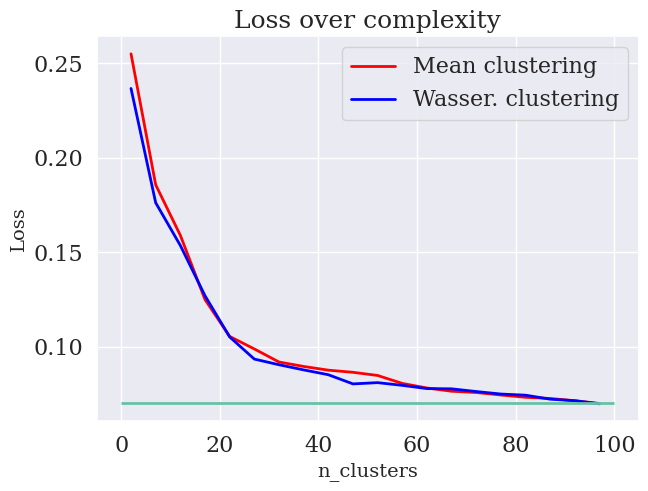

In [ ]:
plt.figure(figsize=(7, 5))
plt.plot(cluster_range, qualities, linewidth=2, c='r', label='Mean clustering')
plt.plot(cluster_range, qualities_wass, linewidth=2, c='b', label='Wasser. clustering')

plt.title('Loss over complexity', fontsize=18)

plt.hlines(0.07, 0, 100)

plt.ylabel('Loss', fontsize=14)
plt.xlabel('n_clusters', fontsize=14)
plt.legend();

одинаково: ковариации не нужны.

#### 5. другой датасет: MNIST clasification

3-х слойная сеть: 784-10-100-10

In [ ]:
import torchvision
from torchvision import transforms
train_data = torchvision.datasets.MNIST("./", train=True, transform=transforms.ToTensor(), download=True)

784

In [ ]:
train_data[0][0].shape

torch.Size([1, 28, 28])

In [ ]:
train_data[0][1]

5

In [ ]:
Другой датасет: win

In [ ]:
len(clusters)

2

Теперь визуализируем нейроны: у них очень малая дисперсия!!!

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(means)

In [ ]:
def change_weights(W1weight, labels):
    '''
        labels: list with ints; We change weight of cluster as mean weight!
    '''
    with torch.no_grad():
        new_weights = copy.deepcopy(W1weight)

        unique_labels = np.unique(labels)

        for lab in unique_labels:
            new_weights[:, labels == lab] = new_weights[:, labels == lab].mean(axis=1, keepdims=True)
        
    return new_weights

In [ ]:
new_weights = change_weights(models[0].W1.weight, kmeans.labels_)

In [ ]:
estimate_quality(new_weights)

0.1818205362026335

In [ ]:
qualities = []

cluster_range = list(range(1, models[0].W1.weight.shape[1], 3))

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit(means)

    new_weights = change_weights(models[0].W1.weight, kmeans.labels_)
    quality = estimate_quality(new_weights)

    qualities.append(quality)
    print(f'clust: {n_clusters}, quality: {quality:.3f}')

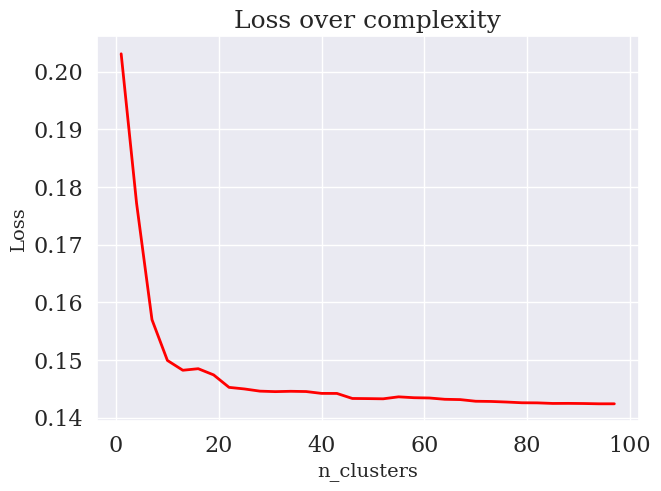

In [ ]:
plt.figure(figsize=(7, 5))
plt.plot(cluster_range, qualities, linewidth=2, c='r')
plt.title('Loss over complexity', fontsize=18)
plt.ylabel('Loss', fontsize=14)
plt.xlabel('n_clusters', fontsize=14);

In [ ]:
import seaborn as sns

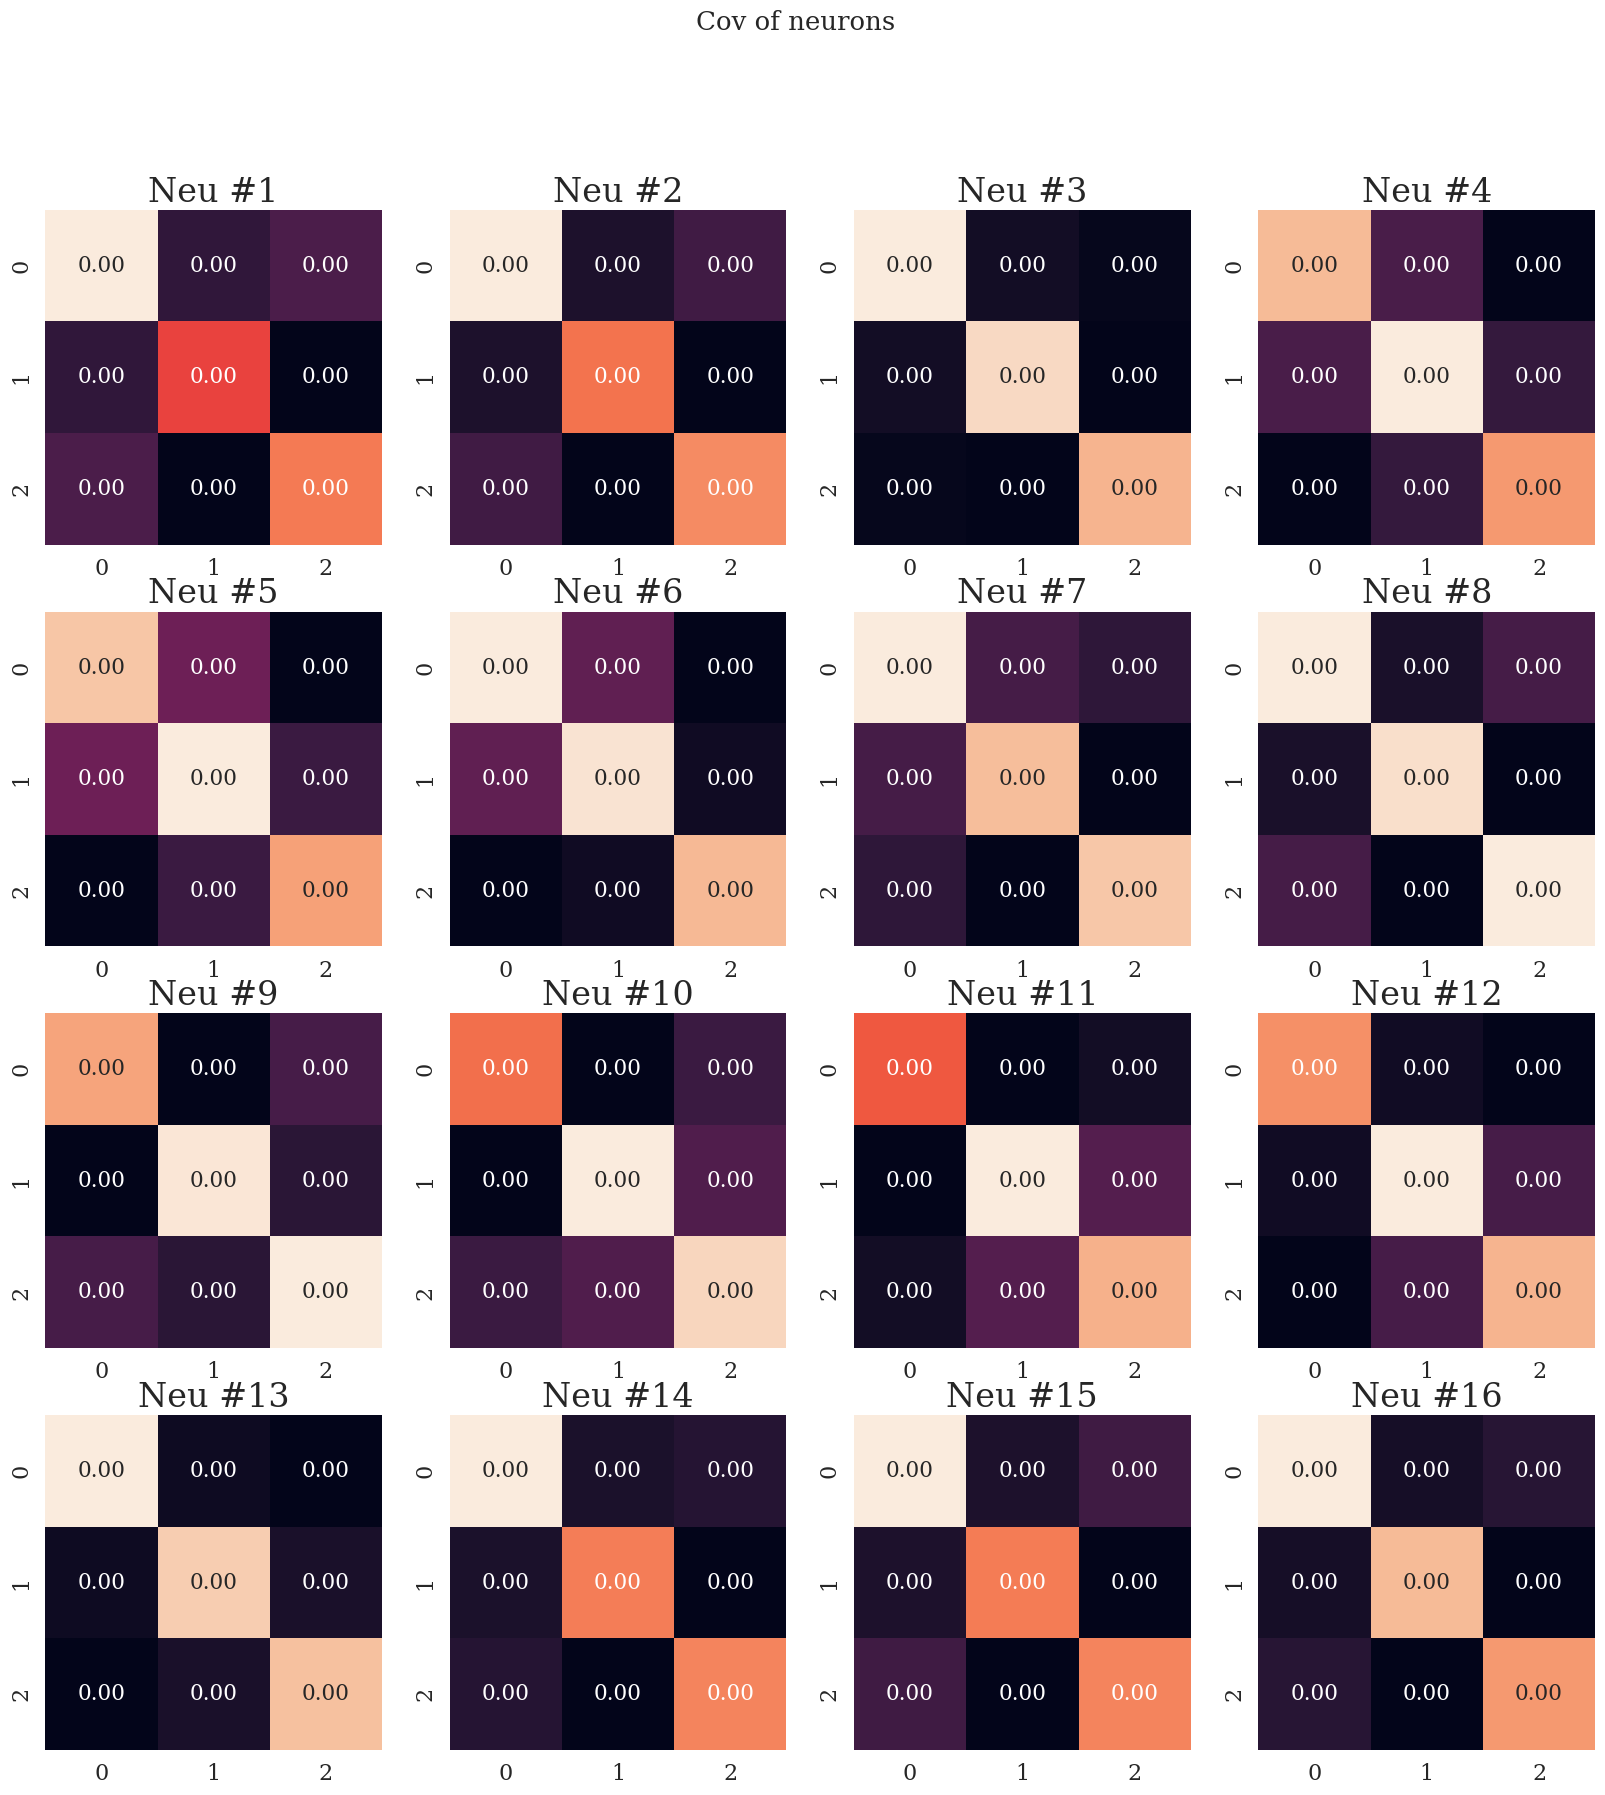

In [ ]:
plot_cov_heatmap(variances[:16])

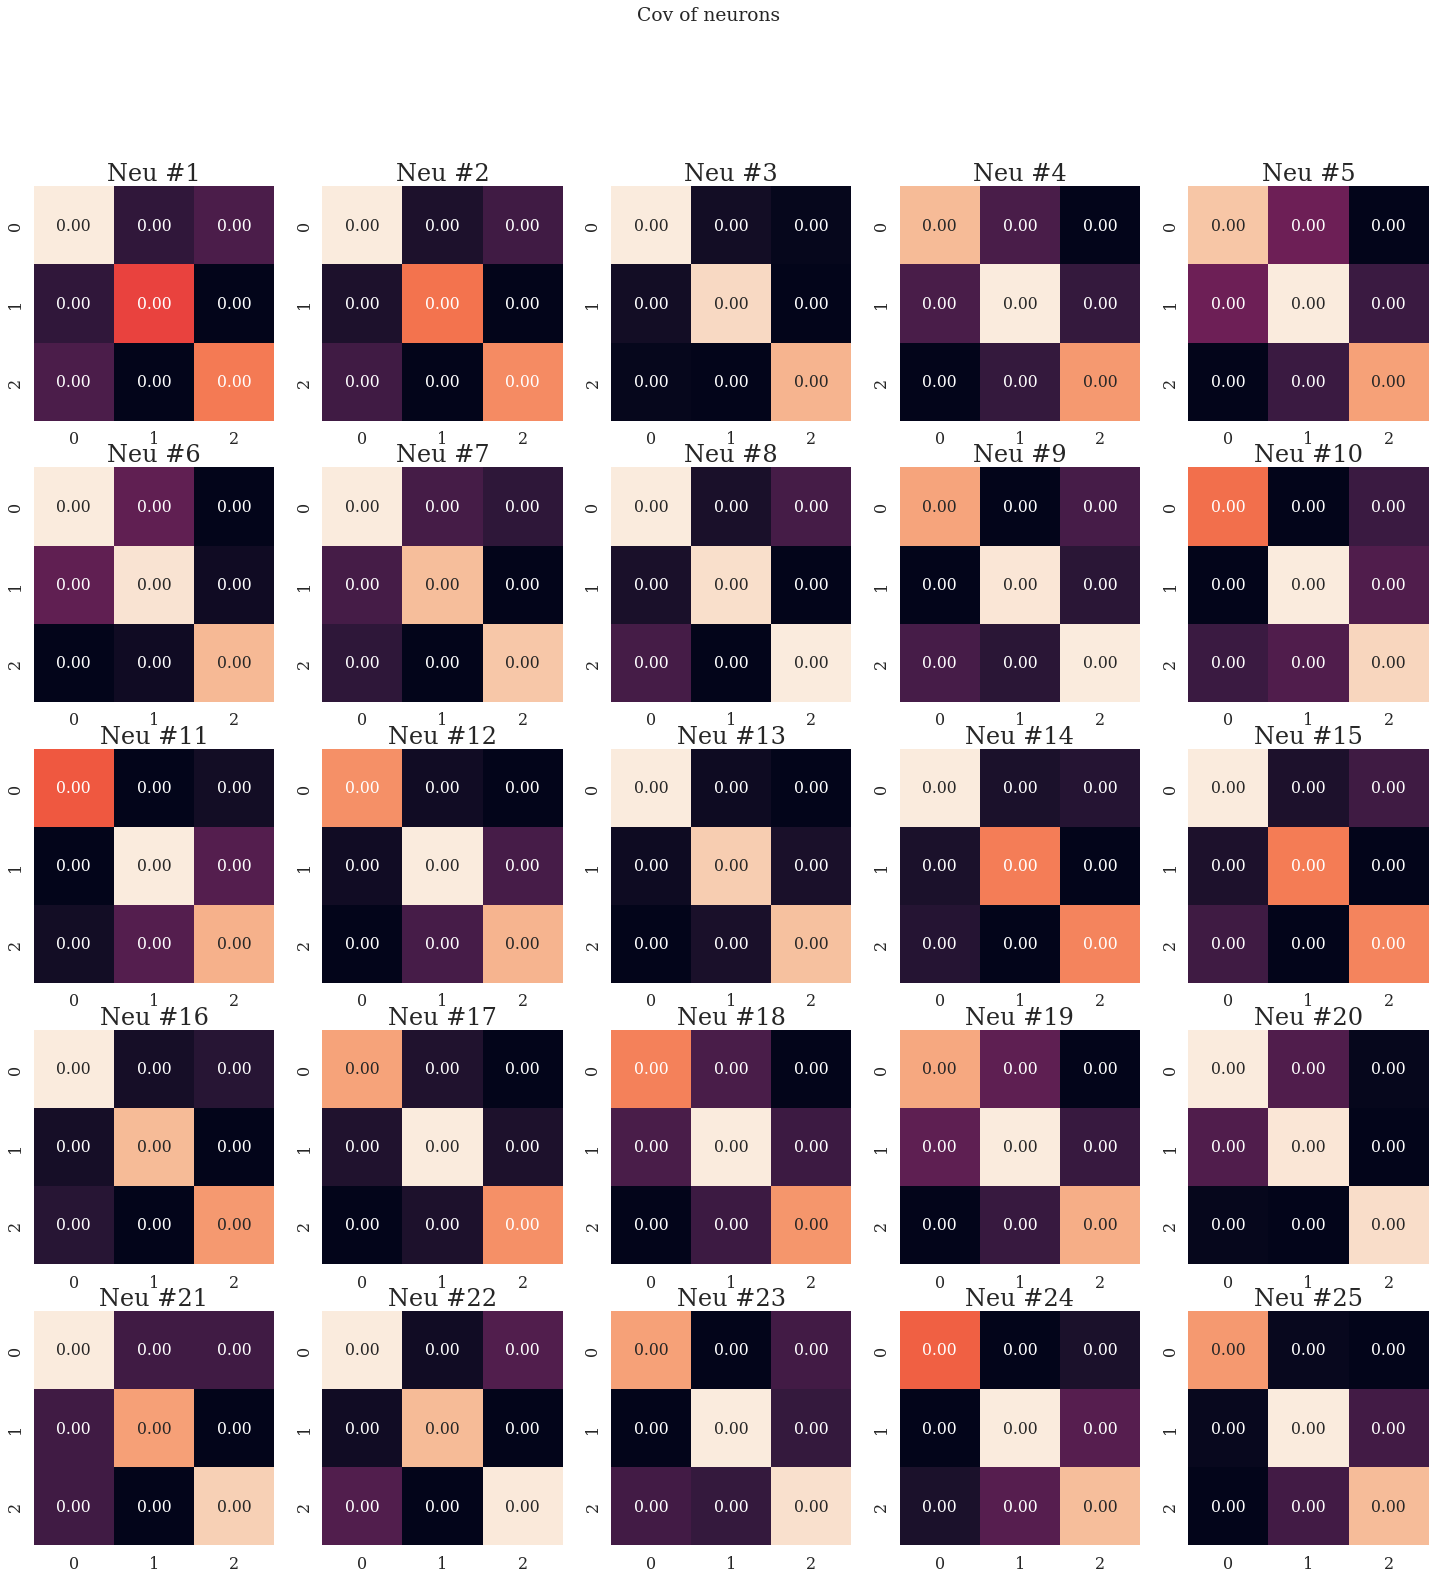

In [ ]:
plot_cov_heatmap(variances[:25], path_to_save='/content/drive/MyDrive/metric_analysis/plots/2nn', 
                  img_name='2NN_nonort_experiment_accel_3d')

In [ ]:
#elevation = 30

In [ ]:
for angle in range(0, 360*4 + 1, 10):
    mu_s, Sigma_s = means[:16], variances[:16]
    alpha = 1
    figsize=(10, 10)

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    # number of ellipsoids 
    ellipNumber = len(mu_s)

    #set colour map so each ellipsoid as a unique colour
    norm = colors.Normalize(vmin=0, vmax=ellipNumber)
    cmap = cm.jet
    m = cm.ScalarMappable(norm=norm, cmap=cmap)

    u = np.linspace(0.0, 2.0 * np.pi, 30)
    v = np.linspace(0.0, np.pi, 30)

    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones_like(u), np.cos(v))

    #compute each and plot each ellipsoid iteratively
    for indx in range(ellipNumber):

        # your ellispsoid and center in matrix form
        A = Sigma_s[indx]
        center = mu_s[indx] 

        ellipsoid = (A @ np.stack((x, y, z), 0).reshape(3, -1) * alpha + center.reshape(3, -1)).reshape(3, *x.shape)

        ax.plot_surface(*ellipsoid,  rstride=2, cstride=2, \
                        color=m.to_rgba(indx), linewidth=0.1, alpha=0.4, shade=False)


    # ax.set_title(f'Neurons confidence areas')
    ax.set_xlabel(f'$x$', fontsize=20)
    ax.set_ylabel(f'$y$', fontsize=20)
    ax.set_zlabel(f'$z$', fontsize=20)


    # Normalize the angle to the range [-180, 180] for display
    angle_norm = (angle + 180) % 360 - 180

    # Cycle through a full rotation of elevation, then azimuth, roll, and all
    elev = azim = roll = 20
    if angle <= 360:
        elev = angle_norm
    elif angle <= 360*2:
        azim = angle_norm
    elif angle <= 360*3:
        roll = angle_norm
    else:
        elev = azim = roll = angle_norm

    # Update the axis view and title
    ax.view_init(elev, azim, roll)
    plt.title('Elevation: %d°, Azimuth: %d°, Roll: %d°' % (elev, azim, roll))

    plt.draw()
    plt.pause(.001)

In [ ]:
def plot_3d_gaussians(mu_s, Sigma_s, figsize=(10, 10), alpha=0.2, path_to_save=None, img_name=None):
    '''
        mu_s = [mu_1, ..., mu_n]; mu_i = (x_i, y_i, z_i) <- mean vectors
        Sigma_s <- variance matrices
        alpha - radius reduce factor
    '''

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    # number of ellipsoids 
    ellipNumber = len(mu_s)

    #set colour map so each ellipsoid as a unique colour
    norm = colors.Normalize(vmin=0, vmax=ellipNumber)
    cmap = cm.jet
    m = cm.ScalarMappable(norm=norm, cmap=cmap)

    u = np.linspace(0.0, 2.0 * np.pi, 30)
    v = np.linspace(0.0, np.pi, 30)

    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones_like(u), np.cos(v))

    #compute each and plot each ellipsoid iteratively
    for indx in range(ellipNumber):

        # your ellispsoid and center in matrix form
        A = Sigma_s[indx]
        center = mu_s[indx] 

        ellipsoid = (A @ np.stack((x, y, z), 0).reshape(3, -1) * alpha + center.reshape(3, -1)).reshape(3, *x.shape)

        ax.plot_surface(*ellipsoid,  rstride=2, cstride=2, \
                        color=m.to_rgba(indx), linewidth=0.1, alpha=0.4, shade=False)
    

    # ax.set_title(f'Neurons confidence areas')
    ax.set_xlabel(f'$x$', fontsize=20)
    ax.set_ylabel(f'$y$', fontsize=20)
    ax.set_zlabel(f'$z$', fontsize=20)

    

    ax.view_init(azim=25, roll=0)
    #ax.view_init(elev, azim, roll)

    if path_to_save is not None:
        if not os.path.exists(path_to_save):
            os.mkdir(path_to_save)

        plt.savefig(path_to_save + '/' + img_name + '.jpg')

    plt.show()

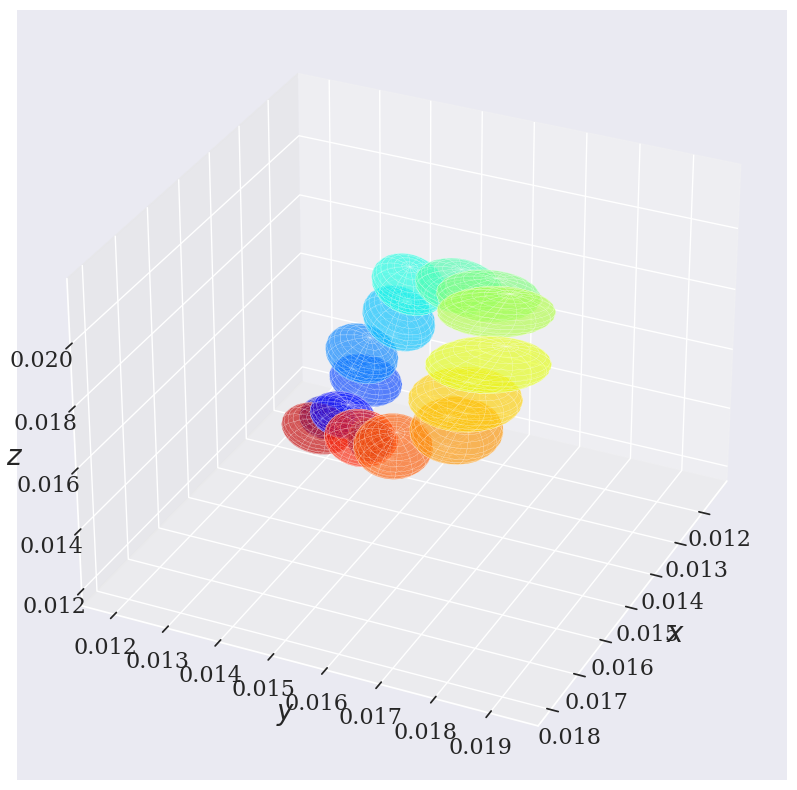

In [ ]:
plot_3d_gaussians(means[:16], variances[:16], alpha=1)

In [ ]:
plot_3d_gaussians_rot(means[:16], variances[:16], alpha=1)

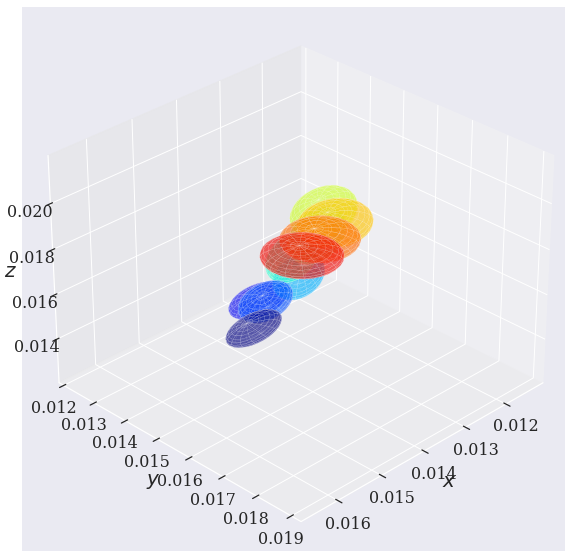

In [ ]:
plot_3d_gaussians(means[:10], variances[:10], alpha=1,
                  path_to_save='/content/drive/MyDrive/metric_analysis/plots/2nn', 
                  img_name='2NN_nonort_experiment_accel_3d_alpha=1')

In [ ]:
plot_3d_gaussians_rot(means[:10], variances[:10], alpha=1, path_to_save='/content/drive/MyDrive/metric_analysis/plots/2nn', 
                  img_name='2NN_nonort_experiment_accel_3d_alpha=1_plotly')

Теперь попробуем 5-мерную

In [ ]:
in_len = steps_in_time
hid_dim = 5
out_len = steps_in_time

batch_size = 16
lr = 1e-3

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)

dataset = TimeSerie_1d_Dataset(in_len=in_len, 
                               out_len=out_len, 
                               s_noice=first_user_data['userAcceleration.x'], 
                               s_true=None)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = NN_2(in_len=in_len, hid_dim=hid_dim, out_len=out_len).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

cpu


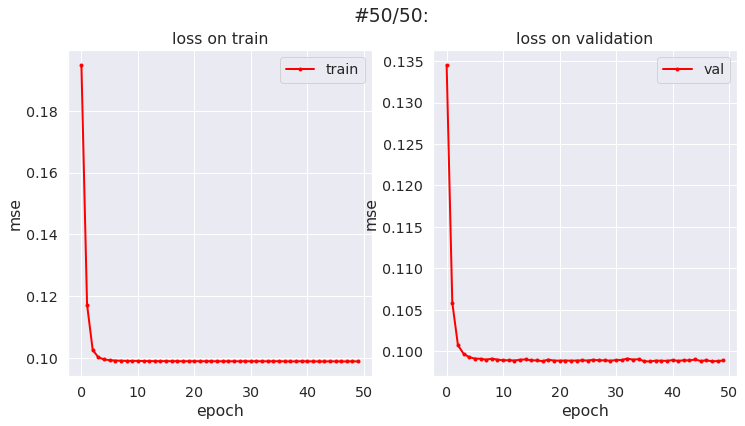

In [ ]:
model, optimizer, losses = learning_loop(
    model = model,
    optimizer = optimizer,
    loader = dataloader,
    criterion = criterion,
    epochs=50,
    draw_every=10,
    separate_show=True,
    device=device
)

In [ ]:
visualize_predictions_go(sec_times, first_user_data['userAcceleration.x'], model, dataset, batch_size, device='cpu')

10-мерная

In [ ]:
in_len = steps_in_time
hid_dim = 10
out_len = steps_in_time

batch_size = 16
lr = 1e-3

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)

dataset = TimeSerie_1d_Dataset(in_len=in_len, 
                               out_len=out_len, 
                               s_noice=first_user_data['userAcceleration.x'], 
                               s_true=None)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = NN_2(in_len=in_len, hid_dim=hid_dim, out_len=out_len).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

cpu


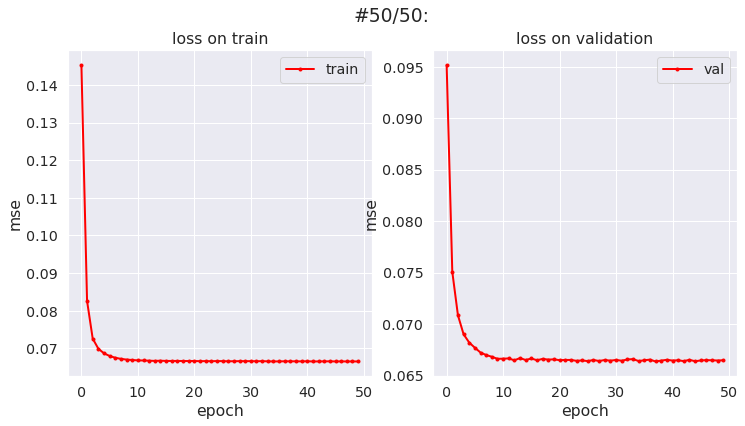

In [ ]:
model, optimizer, losses = learning_loop(
    model = model,
    optimizer = optimizer,
    loader = dataloader,
    criterion = criterion,
    epochs=50,
    draw_every=10,
    separate_show=True,
    device=device
)

In [ ]:
visualize_predictions_go(sec_times, first_user_data['userAcceleration.x'], model, dataset, batch_size, device='cpu')

#### 4. Для большего batch size (чтобы сравниться с другим методом cov estimation)

In [ ]:
in_len = steps_in_time
hid_dim = 3
out_len = steps_in_time

batch_size = 256
lr = 1e-3

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)

dataset = TimeSerie_1d_Dataset(in_len=in_len, 
                               out_len=out_len, 
                               s_noice=first_user_data['userAcceleration.x'], 
                               s_true=None)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = NN_2(in_len=in_len, hid_dim=hid_dim, out_len=out_len).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4, threshold=0.001, verbose=True)

cpu


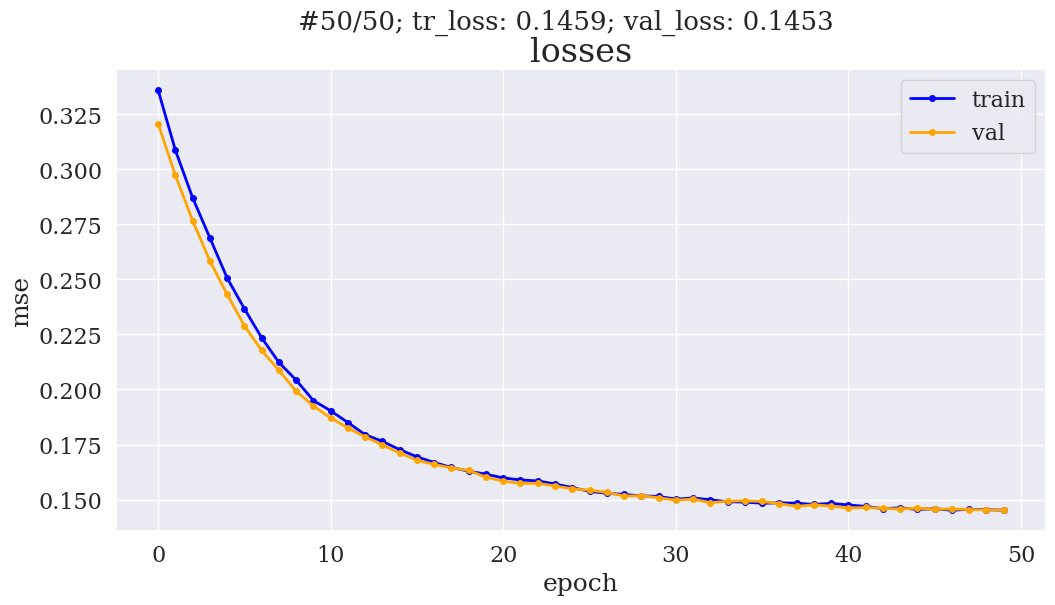

In [ ]:
model, optimizer, losses = learning_loop(
    model = model,
    optimizer = optimizer,
    loader = dataloader,
    criterion = criterion,
    epochs=50,
    draw_every=10,
    separate_show=False,
    device=device
)

In [ ]:
visualize_predictions_go(sec_times, first_user_data['userAcceleration.x'], model, dataset, batch_size, vis_time=10, device=device)

In [ ]:
!pip install torchbnn